In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from tensorflow.keras import backend as K

In [ ]:
class CNN:
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model along with the input shape
    # to be "channels last" and the channels dimension itself
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    
    # if we are using "channels first", update the input shape
    # and channels dimension
    if K.image_data_format() == "channels_first":
      inputShape = (height, width, depth)
      chanDim = 1
      
    # 1st CONV -> RELU -> CONV -> RELU -> POOL layer set
    model.add(Conv2D(32, (3,3), padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    # 2nd CONV -> RELU -> CONV -> RELU -> POOL layer set
    model.add(Conv2D(64, (3,3), padding='same', input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3,3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # 1st (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    # return the constructed network architecture
    return model

In [ ]:
from keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


Implementing the Fashion MNIST training script with Keras

Now that CNN is implemented we can move on to the driver script which:


Loads the Fashion MNIST dataset.

Trains CNN on Fashion MNIST + generates a training history plot.

Evaluates the resulting model and outputs a classification report.

Creates a montage visualization allowing us to see our results visually.

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use("Agg") #The "Agg"  backend is used for Matplotlib so that we can save our training plot to disk.

from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from keras.utils import np_utils
from imutils import build_montages
import numpy as np
import cv2

# Initialize EPOCHS, LR_RATE, BATCH_SIZE
NUM_EPOCHS = 10
INIT_LR = 1e-2
BATCH_SIZE = 10

## if we are using "channels_first" ordering, then reshape the design
## matrix such that the matrix is:
## num_sanples x depth x rows x cols

if K.image_data_format() == 'channels_first':
  X_train = X_train.reshape((X_train.shape[0], 1 , 28, 28))
  X_test = X_test.reshape((X_test.shape[0], 1 , 28, 28))  
else:
  ## Otherwise use "channels_last"
  X_train = X_train.reshape((X_train.shape[0], 28, 28, 1))
  X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)) 
  

  
## Preprocess dataset + prepare data

# Scale data to the frame of [0, 1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

#one=hot encode the training and test labels
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

# initialize the labels names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

In [ ]:
# Initialize the optimizer and model
print("Compiling Model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = CNN.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt, 
                                   metrics=['accuracy'])

# Train The model
print("Training model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                   batch_size=BATCH_SIZE, epochs=NUM_EPOCHS)

Compiling Model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Training model...
Epoch 1/10
6000/6000 [==============================] - 440s 73ms/step - loss: 0.6020 - accuracy: 0.8044 - val_loss: 0.3799 - val_accuracy: 0.8648
Epoch 2/10
6000/6000 [==============================] - 444s 74ms/step - loss: 0.3876 - accuracy: 0.8619 - val_loss: 0.3115 - val_accuracy: 0.8879
Epoch 3/10
6000/6000 [==============================] - 437s 73ms/step - loss: 0.3525 - accuracy: 0.8740 - val_loss: 0.2987 - val_accuracy: 0.8939
Epoch 4/10
6000/6000 [==============================] - 447s 75ms/step - loss: 0.3306 - accuracy: 0.8813 - val_loss: 0.2884 - val_accuracy: 0.8982
Epoch 5/10
6000/6000 [==============================] - 451s 75ms/step - loss: 0.3219 - accuracy: 0.8861 - val_loss: 0.2801 - val_accuracy: 0.9022
Epoch 6/10
6000/6000 [==============================] - 447s 74ms/step - loss: 0.3123 - accuracy: 0.8880 - val_loss: 0.2734 - val_accuracy: 0.9054
Epoch 7/10
6000/6000 [==============================] - 447s 74ms/step - loss: 0.3093 - accuracy: 0.

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                        

In [ ]:
### Save model
###==========================================
from keras.models import load_model 
model.save('/content/gdrive/My Drive/Fashion_MNIST/fashion_mnist_cnn_model.h5') # creates a HDF5 file 'my_model.h5' 

# Final evaluation of the model
scores = model.evaluate(X_train, y_train, verbose=1)
print("Train Score: %.2f%%" % (scores[0]*100))
print("Train Accuracy: %.2f%%" % (scores[1]*100))

############## Final evaluation of the model For Test Set
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score: %.2f%%" % (score[0]*100))
print("Test Accuracy: %.2f%%" % (score[1]*100))

1875/1875 [==============================] - 80s 43ms/step - loss: 0.2353 - accuracy: 0.9197
Train Score: 23.53%
Train Accuracy: 91.97%
313/313 [==============================] - 14s 43ms/step - loss: 0.2755 - accuracy: 0.9064
Test Score: 27.55%
Test Accuracy: 90.64%


In [ ]:
from keras.models import load_model 
#### Load Save nodel
# returns a compiled model 
# identical to the previous one 
mmodel = load_model('/content/gdrive/My Drive/Fashion_MNIST/fashion_mnist_cnn_model.h5')
scores = mmodel.evaluate(X_train, y_train, verbose=1)
print("Train Score Again: %.2f%%" % (scores[0]*100))
print("Train Accuracy Again: %.2f%%" % (scores[1]*100))

############## For Test Set from loading models
score = mmodel.evaluate(X_test, y_test, verbose=1)
print("Test Score Again: %.2f%%" % (score[0]*100))
print("Test Accuracy Again: %.2f%%" % (score[1]*100))

1875/1875 [==============================] - 80s 43ms/step - loss: 0.2353 - accuracy: 0.9197
Train Score Again: 23.53%
Train Accuracy Again: 91.97%
313/313 [==============================] - 14s 43ms/step - loss: 0.2755 - accuracy: 0.9064
Test Score Again: 27.55%
Test Accuracy Again: 90.64%


In [ ]:
# make predictions
preds = mmodel.predict(X_test)

# show the nicely formatted classification report
print("Evaluating network...")
print(classification_report(y_test.argmax(axis=1), preds.argmax(axis=1),
     target_names=labelNames))

Evaluating network...
              precision    recall  f1-score   support

         top       0.88      0.82      0.85      1000
     trouser       0.99      0.98      0.98      1000
    pullover       0.91      0.82      0.86      1000
       dress       0.90      0.92      0.91      1000
        coat       0.80      0.90      0.85      1000
      sandal       0.97      0.98      0.98      1000
       shirt       0.72      0.74      0.73      1000
     sneaker       0.95      0.98      0.96      1000
         bag       0.98      0.97      0.97      1000
  ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
### List all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


KeyError: ignored

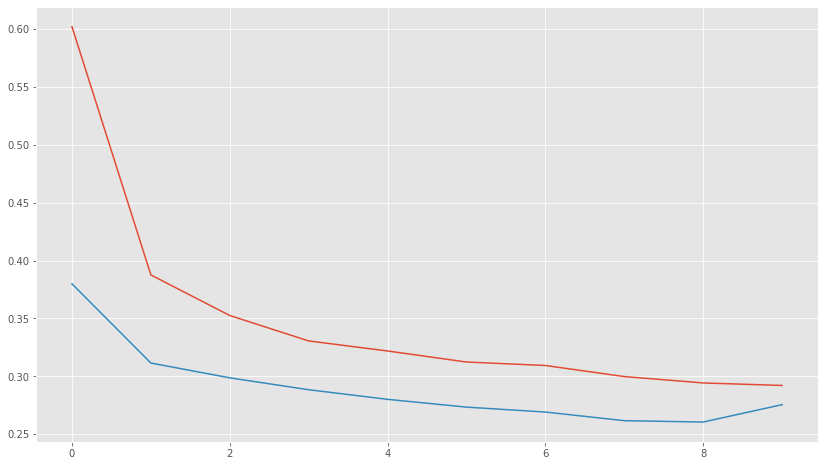

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

#plot the training loss and accuray
plt.style.use("ggplot")
plt.figure(figsize=(14,8))
plt.plot(np.arange(0, NUM_EPOCHS), history.history['loss'], label='train_loss')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['acc'], label='train_acc')
plt.plot(np.arange(0, NUM_EPOCHS), history.history['val_acc'], label='val_acc')
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
# plt.legend(loc="lower left")
# # plt.savefig("plot_perf.png")
plt.legend(loc = 'upper left')
plt.tight_layout()
plt.savefig("/content/gdrive/My Drive/Fashion_MNIST/plot_loss_acc.png", dpi = 50)
plt.show()

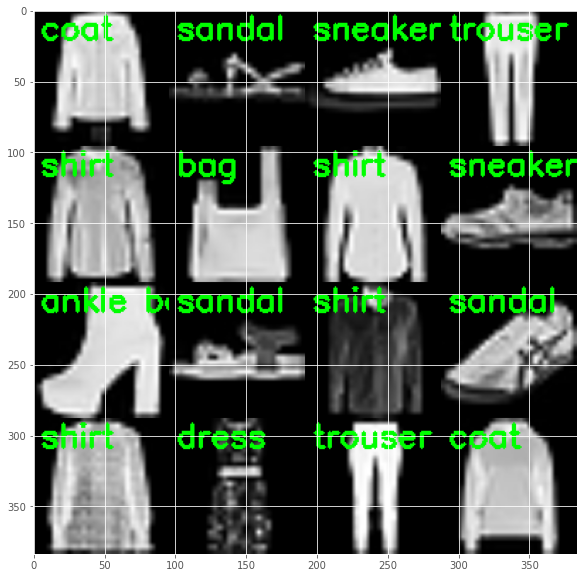

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
# initialize our list of output images
images = []

# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(y_test)), size=(16,)):
	# classify the clothing
	probs = mmodel.predict(X_test[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (X_test[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (X_test[i] * 255).astype("uint8")

	# initialize the text label color as green (correct)
	color = (0, 255, 0)

	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(y_test[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		(0, 255, 0), 2)

	# add the image to our list of output images
	images.append(image)

# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]

# show the output montage
# cv2.imshow("Fashion MNIST", montage)
# cv2.waitKey(0)
plt.imshow(montage, cmap='gray')
plt.show()